In [350]:
import pandas as pd
import numpy as np
from math import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from matplotlib.pyplot import boxplot 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [351]:
# X_train_full = pd.read_csv('../input/train.csv', index_col='Id')
# X_test = pd.read_csv('../input/test.csv', index_col='Id')
X_train_full = pd.read_csv('/Users/avyny/Documents/Data_analyses-Kaggle/Data_House_Pricing/train.csv', index_col='Id')
X_test = pd.read_csv('/Users/avyny/Documents/Data_analyses-Kaggle/Data_House_Pricing/test.csv', index_col='Id')
# X_train_full = pd.read_csv('D:\\Learning_IT\\Data_analyses-Kaggle\\Data_House_Pricing\\train.csv', index_col='Id')
# X_test = pd.read_csv('D:\\Learning_IT\\Data_analyses-Kaggle\\Data_House_Pricing\\test.csv', index_col='Id')

## Separating target value and features
y = X_train_full.SalePrice              
X_train_full.drop(['SalePrice'], axis=1, inplace=True)

In [352]:
## Detecting of NA
missing_val_count_by_column = (X_train_full.isnull().sum())
missing_val_count_by_column[missing_val_count_by_column > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [353]:
## So, a lot of missing values in column 'Alley' - it is better to delete it
# Also I decided to drop 'Utilities' because it's close to constant variable
X_train_full = X_train_full.drop(['Alley', 'Utilities'], axis = 1)
X_test = X_test.drop(['Alley', 'Utilities'], axis = 1)

In [354]:
# Finding outliers in SalePrice
pd.DataFrame(y).sort_values(by = 'SalePrice', ascending = False).head(4)

,SalePrice
Id,
692,755000
1183,745000
1170,625000
899,611657


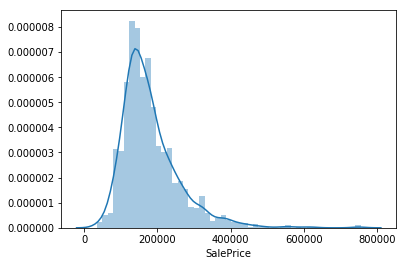

In [355]:
# Density plot for Sale Prices
sns.distplot(y)

In [356]:
### POSSIBLE OUTLIERS

# y = y.drop([692, 1183, 1170, 899], axis = 0)
# X_train_full = X_train_full.drop([692, 1183, 1170, 899], axis = 0)

# The most expensive SalePrice is obsevations # 692, 1183, 1170, 899 (> 600000)

# Huge 'LotArea' in observations # 314, 336, 250, 707 (> 100000 )
# Huge 'LotFrontage' in observations # 1299, 935, 1128 ( > 180 )
# Huge 'GrLivArea'(общая жилая площадь) # 1299, 524, 1183, 692 ( > 4000 )


In [357]:
## Preprocessing data
### Simplifying features
X_train_full['Street'], X_test['Street'] = X_train_full['Street'].map({'Pave': 1, 'Grvl': 0}), X_test['Street'].map({'Pave': 1, 'Grvl': 0})

X_train_full['Condition2'] = X_train_full['Condition2'].apply(lambda z: 1 if z == 'Norm' else 0)
X_test['Condition2'] = X_test['Condition2'].apply(lambda z: 1 if z == 'Norm' else 0)

X_train_full['RoofMatl'] = X_train_full['RoofMatl'].apply(lambda x: 'CompShg' if x == 'CompShg' else 'Tar&Grv' if x == 'Tar&Grv' else 'Others')
X_test['RoofMatl'] = X_test['RoofMatl'].apply(lambda x: 'CompShg' if x == 'CompShg' else 'Tar&Grv' if x == 'Tar&Grv' else 'Others')

X_train_full['Heating'] = X_train_full['Heating'].apply(lambda x: 'GasA' if x == 'GasA' else 'GasW' if x == 'GasW' else 'Others')
X_test['Heating'] = X_test['Heating'].apply(lambda x: 'GasA' if x == 'GasA' else 'GasW' if x == 'GasW' else 'Others')

X_train_full['CentralAir'] = X_train_full['CentralAir'].map({'Y': 1, 'N': 0})
X_test['CentralAir'] = X_test['CentralAir'].map({'Y': 1, 'N': 0})

### Filling NA with variables
X_train_full['LotFrontage'] = X_train_full.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
X_test['LotFrontage'] = X_test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

X_test['BsmtFinSF1'] = X_test['BsmtFinSF1'].fillna(0)
X_test['BsmtFinSF2'] = X_test['BsmtFinSF2'].fillna(0)
X_test['BsmtUnfSF'] = X_test['BsmtUnfSF'].fillna(0)
X_test['TotalBsmtSF'] = X_test['TotalBsmtSF'].fillna(0)
X_train_full['BsmtQual'], X_test['BsmtQual'] = X_train_full['BsmtQual'].fillna('NoBsmt'), X_test['BsmtQual'].fillna('NoBsmt')
X_train_full['BsmtCond'], X_test['BsmtCond'] = X_train_full['BsmtCond'].fillna('NoBsmt'), X_test['BsmtCond'].fillna('NoBsmt')
X_train_full['BsmtExposure'], X_test['BsmtExposure'] = X_train_full['BsmtExposure'].fillna('NoBsmt'), X_test['BsmtExposure'].fillna('NoBsmt')
X_train_full['BsmtFinType1'], X_test['BsmtFinType1'] = X_train_full['BsmtFinType1'].fillna('NoBsmt'), X_test['BsmtFinType1'].fillna('NoBsmt')
X_train_full['BsmtFinType2'], X_test['BsmtFinType2'] = X_train_full['BsmtFinType2'].fillna('NoBsmt'), X_test['BsmtFinType2'].fillna('NoBsmt')

X_test['BsmtFullBath'] = X_test['BsmtFullBath'].fillna(0)
X_test['BsmtHalfBath'] = X_test['BsmtHalfBath'].fillna(0)
X_train_full['FireplaceQu'] = X_train_full['FireplaceQu'].fillna('NoFireplace')
X_test['FireplaceQu'] = X_test['FireplaceQu'].fillna('NoFireplace')

X_train_full['GarageType'], X_test['GarageType']  = X_train_full['GarageType'].fillna('NoGarage'), X_test['GarageType'].fillna('NoGarage')
X_train_full['GarageYrBlt'], X_test['GarageYrBlt']  = X_train_full['GarageYrBlt'].fillna(0), X_test['GarageYrBlt'].fillna(0)
X_train_full['GarageFinish'], X_test['GarageFinish']  = X_train_full['GarageFinish'].fillna('NoGarage'), X_test['GarageFinish'].fillna('NoGarage')
X_train_full['GarageQual'], X_test['GarageQual']  = X_train_full['GarageQual'].fillna('NoGarage'), X_test['GarageQual'].fillna('NoGarage')
X_train_full['GarageCond'], X_test['GarageCond']  = X_train_full['GarageCond'].fillna('NoGarage'), X_test['GarageCond'].fillna('NoGarage')
X_test['GarageCars'] = X_test['GarageCars'].fillna(0)
X_test['GarageArea'] = X_test['GarageArea'].fillna(0)
X_train_full['MasVnrArea'], X_test['MasVnrArea'] = X_train_full['MasVnrArea'].fillna(0), X_test['MasVnrArea'].fillna(0)

X_train_full['PoolQC'], X_test['PoolQC'] = X_train_full['PoolQC'].fillna('NoPool'), X_test['PoolQC'].fillna('NoPool')
X_train_full['Fence'], X_test['Fence'] = X_train_full['Fence'].fillna('NoFence'), X_test['Fence'].fillna('NoFence')

X_train_full['MiscFeature'], X_test['MiscFeature'] = X_train_full['MiscFeature'].fillna('NoMiscFeature'), X_test['MiscFeature'].fillna('NoMiscFeature')


### Creating additional syntetic variables
X_train_full['Total_amt_bathrooms'] = X_train_full.BsmtFullBath + X_train_full.FullBath + 0.5*X_train_full.BsmtHalfBath + 0.5*X_train_full.HalfBath
X_test['Total_amt_bathrooms'] = X_test.BsmtFullBath + X_test.FullBath + 0.5*X_test.BsmtHalfBath + 0.5*X_test.HalfBath

X_train_full['Total_porch_sf'] = X_train_full.OpenPorchSF + X_train_full.EnclosedPorch + X_train_full['3SsnPorch'] + X_train_full.ScreenPorch
X_test['Total_porch_sf'] = X_test.OpenPorchSF + X_test.EnclosedPorch + X_test['3SsnPorch'] + X_test.ScreenPorch

X_train_full['Remodel_aft_building_years'] = X_train_full.YearRemodAdd - X_train_full.YearBuilt
X_test['Remodel_aft_building_years'] = X_test.YearRemodAdd - X_test.YearBuilt

X_train_full['Total_SF'] = X_train_full.TotalBsmtSF + X_train_full['1stFlrSF'] + X_train_full['2ndFlrSF']
X_test['Total_SF'] = X_test.TotalBsmtSF + X_test['1stFlrSF'] + X_test['2ndFlrSF']

X_train_full['Has2ndFloor'] = X_train_full['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
X_test['Has2ndFloor'] = X_test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasFireplace'] = X_train_full['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
X_test['HasFireplace'] = X_test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasBsmt'] = X_train_full['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
X_test['HasBsmt'] = X_test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasGarage'] = X_train_full['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
X_test['HasGarage'] = X_test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasPorch'] = X_train_full['Total_porch_sf'].apply(lambda x: 1 if x > 0 else 0)
X_test['HasPorch'] = X_test['Total_porch_sf'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasPool'] = X_train_full['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
X_test['HasPool'] = X_test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasFence'] = X_train_full['Fence'].apply(lambda x: 1 if x != 'NoFence' else 0)
X_test['HasFence'] = X_test['Fence'].apply(lambda x: 1 if x != 'NoFence' else 0)


### Changin dtypes of some columns
X_train_full['GarageYrBlt'], X_test['GarageYrBlt'] = X_train_full['GarageYrBlt'].astype('int64'), X_test['GarageYrBlt'].astype('int64')

X_train_full = X_train_full.drop('YearRemodAdd', axis=1)
X_test = X_test.drop('YearRemodAdd', axis=1)

In [358]:
## Imputing missing variables with simple imputer for least vars

X_train_full = pd.get_dummies(X_train_full)
X_test = pd.get_dummies(X_test)

si = SimpleImputer(strategy='most_frequent')

X_train_a = pd.DataFrame(si.fit_transform(X_train_full))
X_train_a.columns = X_train_full.columns

X_test_a = pd.DataFrame(si.fit_transform(X_test))
X_test_a.columns = X_test.columns
X_test_a.index = X_test.index

X_train_a, X_test_a = X_train_a.align(X_test_a, join='left', axis=1)

In [359]:
## Deleting possible outliers

# The most expensive SalePrice is obsevations # 692, 1183, 1170, 899 (> 600000)

# Huge 'LotArea' in observations # 314, 336, 250, 707 (> 100000 )
# Huge 'LotFrontage' in observations # 1299, 935, 1128 ( > 180 )
# Huge 'GrLivArea'(общая жилая площадь) # 1299, 524, 1183, 692 ( > 4000 )

## 1183 нужен!
y = y.drop([1183, 692], axis = 0)
X_train_a = X_train_a.drop([1183, 692], axis = 0)

In [360]:
## Splitting variables on train//test sizes
X_train, X_valid, y_train, y_valid = train_test_split(X_train_a, y, train_size = 0.8, test_size = 0.2, random_state = 25)

In [361]:
# y_train = np.log1p(y_train)

In [362]:
# model = XGBRegressor()
# parameters = {'n_estimators': [300, 500, 700, 800, 900],
#               'learning_rate': [.02, .03, .04, .05, .08, .1],
#               'max_depth': [3, 4, 5, 6, 7],
#               'subsample': [.5, .7, .8, 1],
#               'colsample_bytree': [.8, 1]}
# cv = GridSearchCV(model, param_grid=parameters, scoring = 'neg_mean_squared_error')
# cv.fit(X_train, y_train)

In [363]:
# model = XGBRegressor(colsample_bytree = 0.8, learning_rate = 0.03, max_depth = 3, n_estimators= 900, subsample= 0.5)
model = XGBRegressor(n_estimators = 450, learning_rate= 0.04, subsample = 0.5, max_depth = 5, colsample_bytree=0.8)
model.fit(X_train, y_train)

[19:59:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.04, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=450,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5, verbosity=1)

In [364]:
predictions = model.predict(X_valid)
# predictions = np.floor(np.expm1(predictions))

mae = mean_absolute_error(y_valid, predictions)
print("Mean Absolute Error:" , mae)

y_valid = np.array(y_valid)
# base = 2.5611
# # base = 2.494
# rmse = np.sqrt(mean_squared_error((np.log(predictions_2)/np.log(base)), (np.log(y_valid)/np.log(base))))
# rmse = np.sqrt(mean_squared_error(predictions_2, y_valid))
rmse = np.sqrt(mean_squared_error(np.log(predictions), np.log(y_valid)))
print("Root Mean Squared Error:" , rmse)

rmse2 = np.sqrt(mean_squared_error(predictions, y_valid))
print("Root Mean Squared Error:" , rmse2)

Mean Absolute Error: 12689.187352846746
Root Mean Squared Error: 0.11788442479101509
Root Mean Squared Error: 19923.114166472256


In [365]:
## model n_estimators = 450, learning_rate= 0.065, colsample_bytree = 0.8, subsample = 0.8, max_depth = 4, reg_lambda = 0.998
## random_state = 25
## 0.8/0.2 train/test sizes

## WITHOUT outliers
# Mean Absolute Error: 12983   Root Mean Squared Error: 0.1163  Root Mean Squared Error: 22119
# SCORE1 = 14570, SCORE2 = 0.13043 (without logariphm)

## with deleting outlier 1183 
#Mean Absolute Error: 14862.07  Root Mean Squared Error: 0.12970 Root Mean Squared Error: 26221.97
# SCORE1 = 14331.939; SCORE2 =  0.13395
# (LOG 'y' target variable)
#Mean Absolute Error: 14397.342  Root Mean Squared Error: 0.1274  Root Mean Squared Error: 26656.391
# SCORE1 = 14903.59; SCORE2 = 0.13545 

## outliers # 1183, 692, 1299 
# (LOG 'y' target variable)
# Mean Absolute Error: 12706.3   Root Mean Squared Error: 0.116956  Root Mean Squared Error: 19447.849
# SCORE1 = 14185.03429; SCORE2 = 0.12704  (SCORE2 = 0.13230 (without logariphm))

##outliers # 1183, 692, 1299, 524
# Mean Absolute Error: 12503.683   Root Mean Squared Error: 0.11214  Root Mean Squared Error: 18252.242
# SCORE1 = 14361, SCORE2 = 0.12688 (without logariphm)
# (LOG 'y' target variable)
# Mean Absolute Error: 12570.852   Root Mean Squared Error: 0.1099  Root Mean Squared Error: 18159.009
#SCORE2 = 0.13386

##outliers # 1183, 692, 1299, 524, 935, 1128, 1170
# Mean Absolute Error: 12417   Root Mean Squared Error: 0.1000  Root Mean Squared Error: 19126
# SCORE1 = 14515, SCORE2 = 0.12987 (without logariphm)


In [367]:
# preds_test = model.predict(X_test_a)
# preds_test = np.floor(np.expm1(preds_test))
# output = pd.DataFrame({'Id': X_test_a.index,
#                        'SalePrice': preds_test})
# output.to_csv('submission.csv', index=False)